# Supporting Information: Climate Implications of CCS Implementation Timing and Natural Gas Methane Emission Uncertainty

Greg Schivley, Paulina Jaramillo, Constantine Samaras*

*csamaras@cmu.edu


## Description

This IPython Notebook presents code and data used to calculate emissions for supercritical pulvarized coal (SCPC) and natural gas combined cycle (NGCC) power plants that begin operations with, or transition to, carbon capture and storage (CCS). We also examine the uncertainty of current methane emissions from natural gas systems, and what will happen if those emissions are reduced.

In [20]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from ghgforcing import CO2, CH4
import cPickle as pickle
import gzip
import os
import re

import warnings
warnings.simplefilter("once", DeprecationWarning)

## Background Data

### Coal Extraction Emissions

GHG emissions for underground bituminous coal extraction are from the 2014 NETL report *Life Cycle Analysis of Natural Gas Extraction and Power Generation* [(1)](#References). They are 2.69E-2 kg CO<sub>2</sub> and 3.32E-3 kg CH<sub>4</sub> per kg of coal.

### Natural Gas Extraction and Transmission Emissions

Methane emissions in the model are varied parametrically with the leakage rate. For every percent leakage, 1 kg of methane is emitted per 100 kg natural gas delivered. While CO2 emissions may vary with the methane leakage rate, we assume that they are fixed value equal to the 3.8 kg/MJ reported by NETL in 2016.

### Defining Emissions

Our goal is to examine implications of building natural gas plants now rather than coal if advanced coal with CCS might have lower climate impacts than NGCC w/CCS when methane emission rates are above a certain amount.

We start with new plants of each type and examine the following scenarios:

- Fixed methane emission rates from natural gas varied from 1-5%. CCS with 90% capture is included at the start of operations or added after 20 years.
- Emission rates decrease over time, starting at 1-5% and going down to half of the initial rate (minimum of 1%). CCS with 90% capture is included at the start of operations or added after 20 years.
- CCS at 90% capture for the SCPC, but no CCS for the NGCC. Natural gas methane emissions are reduced over time, as above.
- CCS at 16% capture for the SCPC, to match EPA Carbon Pollution Standards limit of 1,400 lb CO<sub>2</sub>/MWh gross. No CCS for the NGCC, both constant and reduced methane emissions.

### Emissions and feedstock value from the 2015 NETL baseline report [(2)](#References):

- SCPC w/o CCS: 773.6 kg CO2/MWh net, 325.8 kg coal/MWh net
    - A plant at 8,379 btu/kWh burning bit coal
- SCPC w 90% CCS: 97.0 kg CO2/MWh net, 408.6 kg coal/MWh net
    - Heat rate of 10,508 btu/kWh. 90% capture on a plant that starts at 8,379 btu/kWh
- SCPC w CCS (82.2% bypass): 682.1 kg CO2/MWh net, 342.0 kg coal/MWh net 
    - **Calculated in PPFM starting with no capture and then adding CCS with 82.2% bypass**
    - Heat rate of 8,795 btu/kWh. Approx. 16% capture on a plant that starts at 8,379 btu/kWh
- NGCC w/o CCS: 353.2 kg CO2/MWh net, 133.4 kg NG/MWh net
    - A plant at 6,629 btu/kWh burning natural gas
- NGCC w 90% CCS: 39.8 kg CO2/MWh net, 150.2 kg NG/MWh net
    - Heat rate of 7,466 btu/kWh. 90% capture on a plant that starts at 6,629 btu/kWh

In the code below:

- Time frame under examination is 100 years, with 0.01 year timesteps
- Power plants operate for 60 years
- CCS is implemented after an amout of time defined by *CCS_start*

In [2]:
size = 1000 # MW
hours = 365 * 24
capacity_factor = 0.8

generation = size * hours * capacity_factor #MWh/yr

end = 100
tstep = 0.01
time = np.linspace(0, end, num=end/tstep+1) #time array
life = 60

### Create tables for the SI

#### Natural gas power plants table

In [11]:
ng_df = pd.DataFrame(index=ng_index, columns=['Leak Rate', 'Heat Rate', 'Efficiency', 'Fuel Input',
                                              'Plant CO2', 'LC CO2', 'LC CH4'])

In [24]:
ng_df.loc[:,'Leak Rate'] = [1,2,3,4,5,1,2,3,4,5]
ng_df.iloc[:5,1] = 6629
ng_df.iloc[5:,1] = 7466
ng_df.loc[:,'Efficiency'] = ng_df.loc[:,'Heat Rate'].map(lambda x: 3412/x)
ng_df.iloc[:5,3] = 133.4
ng_df.iloc[5:,3] = 150.2
ng_df.iloc[:5,4] = 353.2
ng_df.iloc[5:,4] = 39.8
ng_df.loc[:,'LC CH4'] = ng_df.loc[:,'Leak Rate'] * ng_df.loc[:,'Fuel Input'] * 0.01
ng_df.loc[:,'LC CO2'] = ng_df.loc[:,'LC CH4'] * slope + intercept
ng_df.loc[:,'Total CO2'] = ng_df.loc[:,'LC CO2'] + ng_df.loc[:,'Plant CO2']
ng_df

Leak Rate Heat Rate  Efficiency Fuel Input Plant CO2   LC CO2  \
Capture Leak                                                                  
0%      1%            1      6629    0.514708      133.4     353.2  6.83603   
        2%            2      6629    0.514708      133.4     353.2  13.4984   
        3%            3      6629    0.514708      133.4     353.2  20.1607   
        4%            4      6629    0.514708      133.4     353.2   26.823   
        5%            5      6629    0.514708      133.4     353.2  33.4853   
90%     1%            1      7466    0.457005      150.2      39.8  7.67506   
        2%            2      7466    0.457005      150.2      39.8  15.1764   
        3%            3      7466    0.457005      150.2      39.8  22.6778   
        4%            4      7466    0.457005      150.2      39.8  30.1792   
        5%            5      7466    0.457005      150.2      39.8  37.6805   

             LC CH4 Total CO2  
Capture Leak                   
0%      1%    1.334   360.036  
        2%    2.668   366.698  
        3%    4.002   373.361  
        4%    5.336   380.023  
        5%     6.67   386.685  
90%     1%    1.502   47.4751  
        2%    3.004   54.9764  
        3%    4.506   62.4778  
        4%    6.008   69.9792  
        5%     7.51   77.4805

In [26]:
ng_df.to_csv('Natural gas SI table.csv')

#### Coal power plants table

In [20]:
c_df = pd.DataFrame(index=['0%', '16%', '90%'], columns=['Heat Rate', 'Efficiency', 'Fuel Input',
                                              'Plant CO2', 'LC CO2', 'Total CO2', 'LC CH4'])

In [23]:
c_df.loc[:,'Heat Rate'] = np.array([8379, 8795, 10508])
c_df.loc[:,'Efficiency'] = 3412 * 100 / np.array([8379, 8795, 10508])
c_df.loc[:,'Fuel Input'] = np.array([325.8, 342.0, 406.8])
c_df.loc[:, 'Plant CO2'] = np.array([773.6, 682.1, 97.0])
c_df.loc[:, 'LC CO2'] = c_df.loc[:,'Fuel Input'] * 3.75E-2
c_df.loc[:, 'Total CO2'] = c_df.loc[:,'Plant CO2'] + c_df.loc[:,'LC CO2']
c_df.loc[:, 'LC CH4'] = c_df.loc[:,'Fuel Input'] * 7.64E-03

In [24]:
c_df

,Heat Rate,Efficiency,Fuel Input,Plant CO2,LC CO2,Total CO2,LC CH4
0%,8379,40.720850,325.8,773.6,12.2175,785.8175,2.489112
16%,8795,38.794770,342.0,682.1,12.8250,694.9250,2.612880
90%,10508,32.470499,406.8,97.0,15.2550,112.2550,3.107952


In [26]:
c_df.to_csv('Coal SI table.csv')

## Define emissions

In [10]:
def emissions(CCS_start = 0, leakage_drop_by = 10, 
              leak_values=[1, 2, 3, 4, 5], year_to_90CSS=20):
    #Natural gas 
    #Values per leak were calculated using the 2014 NETL Natural Gas report (1) to build a model
    #of Marcellus extraction in OpenLCA. We used expected, high, and low parameter values 
    #to build a relationship between methane and CO2 emissions. The OpenLCA model will be 
    #available on github.
    
    leak = {} # dictionary of leak values
    for value in leak_values:
        # Raise a UserWarning if integers could have been passed rather than floats
        if (type(value) == float) and (value - int(value) == 0):
            raise UserWarning('You passed floats when integers were appropriate')
        
        key = 'NGCC ' + str(value) + '%' # define the key for a leak value
        leak[key] = float(value) # Add key and value to the dictionary
    
    # Hardcoded/calculated emission values for natural gas and NGCC plants
    Mbtu_to_MJ = 1.05506 # MJ per Mbtu, used for heat rate conversion
    ngcc_ng = 133.4 #kg NG for 1MWh NGCC w/o CCS from PPFM
    ngcc_ccs_ng = 150.2 #kg NG for 1MWh NGCC w CCS from PPFM
    ngcc_MJ = 6629 * Mbtu_to_MJ # Convert btu/kWh heat rate to MJ/MWh
    ngcc_ccs_MJ = 7466 * Mbtu_to_MJ # Convert btu/kWh heat rate to MJ/MWh
    CH4_per_kg_leak = 0.01 #kg methane per % emission per kg NG
    CO2_per_MJ = 3.8 / 1000 #kg CO2 per % emission per MJ NG

    CH4_per_leak =  ngcc_ng * CH4_per_kg_leak
    CH4_per_leak_CCS = ngcc_ccs_ng * CH4_per_kg_leak
    base_CO2 = 353.2 + CO2_per_MJ * ngcc_MJ
    base_CO2_CCS = 39.8 + CO2_per_MJ * ngcc_ccs_MJ
    
    # Dictionary of emission values for NGCC power plants
    # Leak emissions are per percent leakage rate
    ng_emissions = {'0%': {'Fixed': {'CO2': base_CO2,
                                       'CH4': 0},
                               'Leak': {'CO2': 0,
                                       'CH4': CH4_per_leak}
                             },
                     '90%': {'Fixed': {'CO2': base_CO2_CCS,
                                       'CH4': 0},
                               'Leak': {'CO2': 0,
                                       'CH4': CH4_per_leak_CCS}
                             }
                   }



    # Hardcoded/calculated emission values for coal and SCPC plants
    coal_co2 = 3.75E-2 #kg co2 per kg I6 coal from NETL 2014 NG report
    coal_ch4 = 7.64E-03 #kg ch4 per kg I6 coal from NETL 2014 NG report
    scpc_coal = 325.8 #kg coal for 1MWh SCPC w/o CCS from PPFM
    scpc_direct_co2 = 773.6 #kg co2 from 1MWh SCPC w/o CCS from PPFM
    scpc_co2 = scpc_direct_co2 + (scpc_coal * coal_co2)
    scpc_ch4 = scpc_coal * coal_ch4
    scpc_ccs_coal = 408.6 #kg coal for 1MWh SCPC w/ CCS from PPFM
    scpc_ccs_co2 = 97 #kg co2 from 1MWh SCPC w/ CCS from PPFM
    scpc_ccs_co2_product = 873.1 #kg co2 product from 1MWh SCPC w/ CCS from PPFM
    scpc_ccs_co2 = scpc_ccs_co2 + (scpc_ccs_coal * coal_co2)
    scpc_ccs_ch4 = scpc_ccs_coal * coal_ch4

    # All 111b values are based on emissions of 1,400 lb/MWh gross from final rule
    scpc_111b_coal = 342.0 #kg coal for 1MWh SCPC w/ CCS from PPFM
    scpc_111b_co2 = 682.1 #kg co2 from 1MWh SCPC w/ CCS from PPFM
    scpc_111b_co2_product = 122 #kg co2 product from 1MWh SCPC w/ CCS from PPFM
    scpc_111b_co2 = scpc_111b_co2 + (scpc_111b_coal * coal_co2)
    scpc_111b_ch4 = scpc_111b_coal * coal_ch4
    
    # Dictionary of emission values for NGCC power plants
    coal_emissions = {'90%': {'CO2':scpc_ccs_co2,
                              'CH4': scpc_ccs_ch4},
                      '0%': {'CO2':scpc_co2,
                              'CH4':scpc_ch4},
                      '16%':{'CO2':scpc_111b_co2,
                              'CH4': scpc_111b_ch4}
                     }

    
    leakage = pd.DataFrame(index=time, columns=leak.keys())
    leakage_drop = pd.DataFrame(index=time, columns=leak.keys())

    for rate in leak.keys():
        #Initial methane emission (or leak) rate
        leakage.loc[:,rate] = leak[rate]

        #Methane emission rate that drops over time. Starts at initial, with a linear
        #decrease until half of initial.
        leakage_drop.loc[:,rate] = leak[rate]
        if rate != 'NGCC 1%':
            # Use linspace to interpolate between values
            leakage_drop.loc[:leakage_drop_by,rate] = np.linspace(leak[rate], leak[rate]/2,
                                                                 leakage_drop_by/tstep+1)
            leakage_drop.loc[leakage_drop_by:life,rate] = leak[rate]/2
            leakage_drop.loc[life:,rate] = 0
    
    df_list = []      
    
    # NGCC emissions - don't worry about delayed CCS yet
    for l in leak.keys():
        for ccs in ng_emissions.keys():
            # Constant methane
            df = pd.DataFrame(index=time, 
                              columns=['CO2', 'CH4', 'Leak', 'CCS', 'Fuel', 'Methane', 'Start year'])
            df['Start year'] = CCS_start
            df['Methane'] = 'Constant'
            df['Fuel'] = 'NG'
            df['CCS'] = ccs
            df['Leak'] = l
            df['CO2'] = ng_emissions[ccs]['Fixed']['CO2']
            df['CH4'] = ng_emissions[ccs]['Leak']['CH4'] * leakage[l]
            
            # This gets complicated when accounting for delayed CCS start
            if CCS_start > 0:
                df.loc[:CCS_start,'CO2'] = (ng_emissions['0%']['Fixed']['CO2'] * 
                                            np.ones_like(leakage.loc[:CCS_start,l]))
                df.loc[:CCS_start,'CH4'] = ng_emissions['0%']['Leak']['CH4'] * leakage.loc[:CCS_start,l]
            df.loc[60:,['CO2', 'CH4']] = 0
            df_list.append(df)
            
            # Reduced methane
            df = pd.DataFrame(index=time, 
                              columns=['CO2', 'CH4', 'Leak', 'CCS', 'Fuel', 'Methane', 'Start year'])
            df['Start year'] = CCS_start
            df['Methane'] = 'Reduce'
            df['Fuel'] = 'NG'
            df['CCS'] = ccs
            df['Leak'] = l
            df['CO2'] = ng_emissions[ccs]['Fixed']['CO2']
            df['CH4'] = ng_emissions[ccs]['Leak']['CH4'] * leakage_drop[l]

            # This gets complicated when accounting for delayed CCS start
            if CCS_start > 0:
                df.loc[:CCS_start,'CO2'] = (ng_emissions['0%']['Fixed']['CO2'] * 
                                            np.ones_like(leakage_drop.loc[:CCS_start,l]))
                df.loc[:CCS_start,'CH4'] = ng_emissions['0%']['Leak']['CH4'] * leakage_drop.loc[:CCS_start,l]
            df.loc[60:,['CO2', 'CH4']] = 0
            df_list.append(df)
                
                    
    # SCPC emissions
    for ccs in coal_emissions.keys():
        df = pd.DataFrame(index=time, 
                              columns=['CO2', 'CH4', 'Leak', 'CCS', 'Fuel', 'Methane', 'Start year'])
        df['Start year'] = CCS_start
        df['Methane'] = None
        df['Fuel'] = 'Coal'
        df['CCS'] = ccs
        df['Leak'] = 'SCPC' 
        df['CO2'] = coal_emissions[ccs]['CO2'] 
        df['CH4'] = coal_emissions[ccs]['CH4']
        df.loc[60:,['CO2', 'CH4']] = 0
        
        if CCS_start > 0:
            df.loc[:CCS_start,'CO2'] = coal_emissions['0%']['CO2']
            df.loc[:CCS_start,'CH4'] = coal_emissions['0%']['CH4']
        df_list.append(df)
            
    emissions_df = pd.concat(df_list)
    
    # Add one more scenario for CCS that goes from 16% to 90%
    if year_to_90CSS > 0 and CCS_start == 0:
        df = emissions_df[emissions_df['CCS'] == '16%']
        df_90 = emissions_df[(emissions_df['Fuel'] == 'Coal') & (emissions_df['CCS'] == '90%')]
        df.loc[year_to_90CSS:,['CO2', 'CH4']] = df_90.loc[year_to_90CSS:,['CO2', 'CH4']]
        df.loc[:,'CCS'] = '16%-90%'
        emissions_df = pd.concat([emissions_df, df])
        df_list.append(df)
    
    # Set values in the Time column and reset index in both the large dataframe
    # and each of the individual dataframes
    emissions_df.loc[:,'Time'] = emissions_df.index
    emissions_df.reset_index(drop=True, inplace=True)
    
    for df in df_list:
        df.loc[:,'Time'] = df.index
        df.reset_index(drop=True, inplace=True)
 
    return emissions_df, df_list

In [11]:
start_emissions, start_list = emissions(leak_values=range(1,11))
delay_emissions, delay_list = emissions(CCS_start=20, leak_values=range(1,11))

### Sample emission plots (these will be improved)

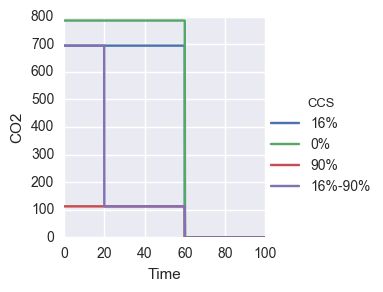

In [12]:
g = sns.FacetGrid(start_emissions[(start_emissions['Fuel']=='Coal')], hue='CCS')
g.map(plt.plot, 'Time', 'CO2')
g.add_legend()

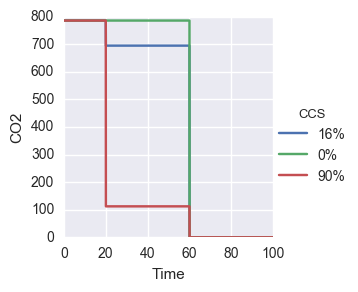

In [13]:
g = sns.FacetGrid(delay_emissions[(delay_emissions['Fuel']=='Coal')], hue='CCS')
g.map(plt.plot, 'Time', 'CO2')
g.add_legend()

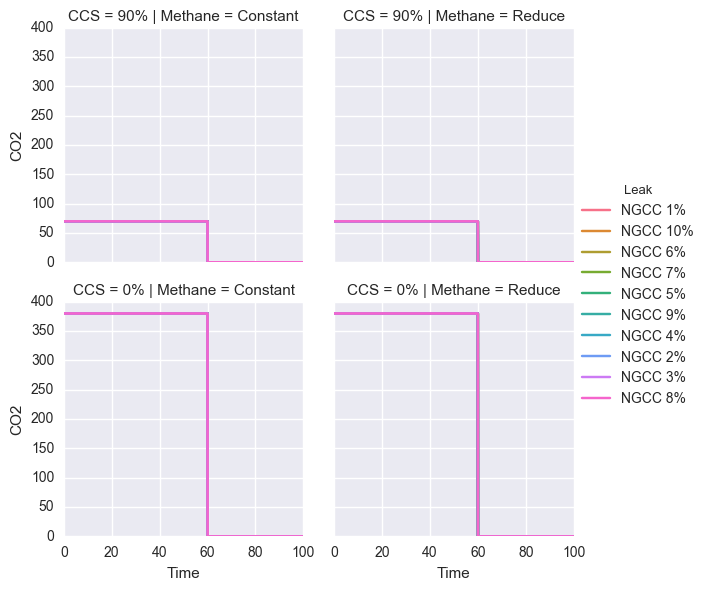

In [14]:
g = sns.FacetGrid(start_emissions[(start_emissions['Fuel']=='NG')], row='CCS', hue='Leak', col='Methane')
g.map(plt.plot, 'Time', 'CO2')
g.add_legend()

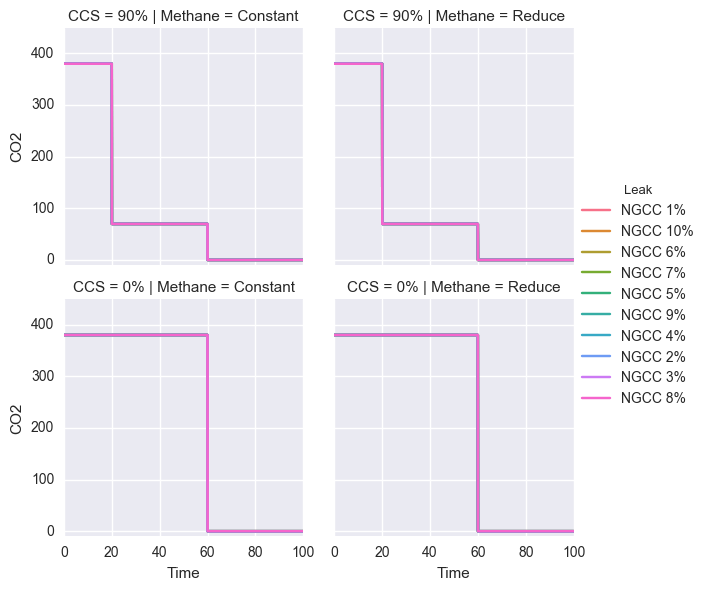

In [15]:
g = sns.FacetGrid(delay_emissions[(delay_emissions['Fuel']=='NG')], row='CCS', col='Methane', hue='Leak',
                 xlim=(0,100), ylim=(-10,450))
g.map(plt.plot, 'Time', 'CO2')
g.add_legend()

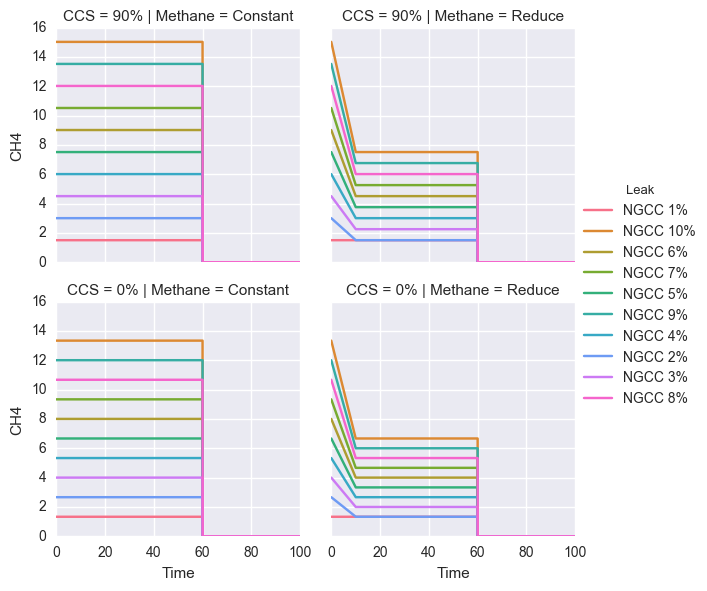

In [16]:
g = sns.FacetGrid(start_emissions[(start_emissions['Fuel']=='NG')], row='CCS', hue='Leak', col='Methane')
g.map(plt.plot, 'Time', 'CH4')
g.add_legend()

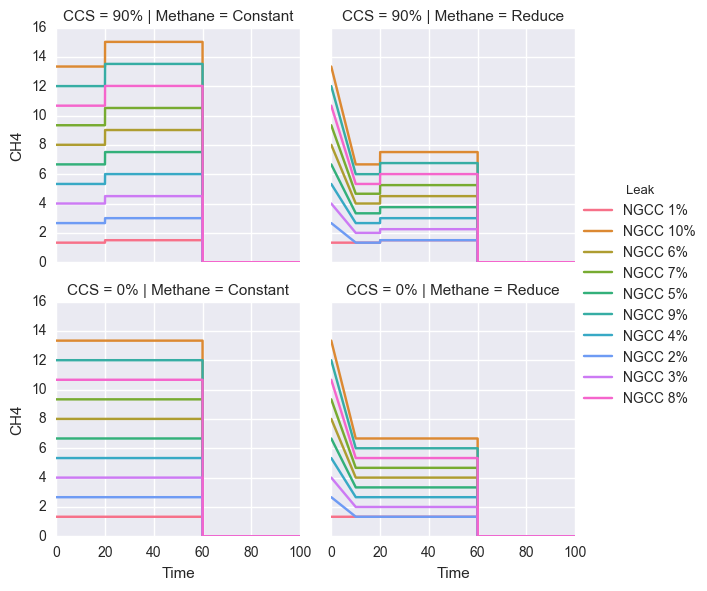

In [18]:
g = sns.FacetGrid(delay_emissions[(delay_emissions['Fuel']=='NG')], row='CCS', hue='Leak', col='Methane')
g.map(plt.plot, 'Time', 'CH4')
g.add_legend()

In [21]:
export_dict = {'start_emissions' : start_emissions,
               'start_list' : start_list,
               'delay_emissions' : delay_emissions,
               'delay_list' : delay_list}

In [22]:
# pickle with gzip, from http://stackoverflow.com/questions/18474791/decreasing-the-size-of-cpickle-objects
def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol)

In [24]:
export_path = os.path.join('../Data', 'emissions 1-10 percent.pgz')
save_zipped_pickle(export_dict, export_path)